# Baseline Model - Deep Neural Network Reinforcement Learning

The baseline model will train an agent to manipulate two DMC's in series to maximize production. Instead of building a Q-table, the agent will learn a policy by approximating a reward function through neural networks.

In [ ]:
from structure import DMC_structure
from dmc import DMC_controller
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import copy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

### Explanation of DMC_controller, DMC_structure, and data generation.
A major component of the model is the data generation and simulation. Because all the data is generated, it is crucial to create is accurately. The two main classes are DMC_controller and DMC_structure. 

As a reminder, the agent only has access to the input and output of the DMC (temperature, pressure, Keq), as well as the constraints of the DMC. Any functions within the DMC are a "black box". This black box is represented by DMC_controller. 

#### DMC_controller
This is a generic class that defines a given DMC. The only initialization needed for a given DMC is the function name. It is very important to know that the agent does not have direct access to any of the functions in this class to preserve the notion that the DMC internals are a black box. The functions included in this class are as follows:
- **_DMC1(Tcurr, Tset), _DMC2(Tcurr, Tset):** These are the functions that return the next temperature, pressure, and Keq based on the input temperature. The current function only requires input temperature, but a DMC can easily use more input parameters with the current function construction. 

    DMCs currently have a maximum temperature change that they can achieve per time step. This is for two main reasons. First, it is unrealistic to assume that a DMC can instantaneously achieve the goal temperature. Second, if the simulated DMCs do instantaneously achieve the goal temperature, then each DMC will be "perfect" all the time, rendering the agent useless. As such, we cap the change to one tenth of the difference of the goal and current temperature. Because we also introduced randomness to the outputs (by 5 degrees), we do not cap the temperature change within 5 degrees. This prevents random walk behavior.
- **DMC1constraints(), DMC2constraints():** These return the constraints of the DMC. This was included in DMC_controller because all DMC information is contained in this class. 
- **getConstraints():** A simple getter that returns the constraints of the DMC. Because the DMC type is defined at initialization (via function name), it will return the correct constraints based on the initalized type.
- **update(goal, inputList):** calls either _DMC1 or _DMC2 based on the type

#### DMC_structure
This is what contains the iteration functionality as well as getters/setters for the goal and constraints. It is initialized via an array of DMCs, which is explained in the next section. Functions include:
- **setGoal(DMCnumber, newGoal):** Set the goal of a given DMC. The goal for the current DMC setup is simply the Keq, but can be modified to be different later. 
- **getConstraints()(DMCnumber):** Get the constraints as well as the output for a given DMC. The current output is:    
    ```
    [
        [currentTemperature, [lowerTemperatureBound, upperTemperatureBound]],
        [currentPressure, [lowerPressureBound, upperPressureBound]],
        [currentKeq, [lowerKeqBound, upperKeqBound]]
    ]
    ```
- **iterate():** This is what the agent uses to update a DMC for a single time step. For each DMC, it first gets the appropriate DMC_controller. It calls update based on the goal and input, and then it updates the appropriate outputs. The current assumption is that each DMC only has one input. Later models will be able to support multi-DMC inputs. 

#### DMC chain
Each DMC in the DMC array is initialized as:
```
    [index (DMC ID), connected DMCs, DMC function type, goal, input array (temperature, pressure, Keq)]
```
It is important to note the following points:
- The first DMC accepts itself as an input. The current model has a static input stream (temperature, pressure, Keq are constant). With the way that the DMC functions are designed, the first DMC needs to be able to "remember" what its adjusted temperature is, otherwise the temperature cap may interfere with the agent. 
- The final value in the array is the input to the DMC. For example, for `[0, [0, 1], "DMC1", 400, [350, 5, 1]]`, the input for DMC0 at the next time step is `[350, 5, 1]`. This allows us to update the DMC in iterate() in linear time. For very computationally intensive agents, this is a critical design decision. 

Visualization of chain (excluding the self-loop for DMC 0):

```mermaid
graph LR
    A["input [T, P, Keq]"] --> B["DMC0"] --> C["DMC1"] --> D["output"]
```

#### Visualization of information flow
Below is a visualization of the information flow for the DMCs and agent. It covers everything mentioned above, in a graphical format.



```mermaid
graph TD
    subgraph agent
    genData["generate_data(goals, DMCarr)"] --> updateGoals["update goals"] --> structInit["initialize DMC structure"] --> iterate["call struct.iterate()"] --> getReward["reward_function(struct, output)"] --> retReward["return the reward"]
    end
    subgraph DMC_structure
    iterate -.-> A["Iterate through each DMC in DMCarr"] --> contInit["DMC_controller(DMCfunc): Initialize DMC controller"] --> update["struct.update(DMCgoal, DMCinput), get output"] --> update2["update DMC inputs/outputs, DMCarr"] -.-> getReward
    getReward -.-> E["struct.getConstraints()"] -.-> F -.-> getReward
    end
    subgraph DMC_controller
        contInit -.-> B["set function"] -.-> contInit
        update -.-> C["call DMC function"] --> D["return new output"] -.-> update2
        B --> C
        F["Return constraints for the specific DMC"]
    end

```



As per the format explained above, the DMC chain is initialized below.

In [ ]:
DMCarr = [[] for i in [0, 1]]
            # index, next, func, goal, input (T, P, Keq)
DMCarr[0] = [0, [0, 1], "DMC1", 400, [350, 5, 1]]
DMCarr[1] = [1, [], "DMC2", 500, [350, 5, 1]]
# DMCarr[2] = [2, [], "Dummy", 0, [0, 0, 0]]

print("DMC array:", DMCarr)
struct = DMC_structure(DMCarr)

DMC array: [[0, [0, 1], 'DMC1', 400, [350, 5, 1]], [1, [], 'DMC2', 500, [350, 5, 1]]]


To further illustrate how the data generation works, here is a sample runthrough with the input to the first DMC changing to 200 degrees at step 50. This temperature change is so large that the second dmc (DMC1) cannot immediately compensate, so that dips as well. At time step 75, the goal for DMC0 changes so low that DMC1 can't keep up with the temparature change. This illustrates the following points:

1. Our DMC models sufficiently handle randomness without demonstrating random walk behavior. 
2. Our DMC models properly handle large temperature changes. 
3. Our DMC models realistically handle not being able to change temperature past a certain point. In other words, it demonstrates physical limitations of the heating/cooling mechansisms. 

The red and green lines represent the goals, and the orange and blue lines represent the outputs of the DMC. 

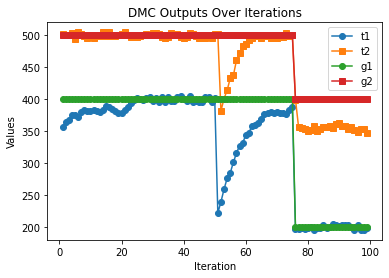

In [ ]:
example_DMCarr = [[] for i in [0, 1]]
            # index, next, func, goal, input (T, P, Keq)
example_DMCarr[0] = [0, [0, 1], "DMC1", 400, [350, 5, 1]]
example_DMCarr[1] = [1, [], "DMC2", 500, [350, 5, 1]]

example_struct = DMC_structure(example_DMCarr)

example_o1 = [[] for i in range(100)]
example_o2 = [[] for i in range(100)]
example_goals1 = [[] for i in range(100)]
example_goals2 = [[] for i in range(100)]

for i in range(99):
    if i == 50:
        example_DMCarr[0][-1] = [200, 5, 1]
    if i == 75:
        example_DMCarr[0][-2] = 200
        example_DMCarr[1][-2] = 400
    example_o2[i] = example_struct.iterate()
    example_o1[i] = example_DMCarr[1][-1]
    
    example_goals1[i] = example_DMCarr[0][3]
    example_goals2[i] = example_DMCarr[1][3]
    
    
example_t1 = [output[0] for output in example_o1 if output]  # Extracting T values
example_t2 = [output[0] for output in example_o2 if output]  # Extracting T
example_h1 = [goal for goal in example_goals1 if goal]
example_h2 = [goal for goal in example_goals2 if goal]
example_iterations = list(range(1, len(example_t1) + 1))

plt.plot(example_iterations, example_t1, label="t1", marker='o')
plt.plot(example_iterations, example_t2, label="t2", marker='s')
plt.plot(example_iterations, example_h1, label="g1", marker='o')
plt.plot(example_iterations, example_h2, label="g2", marker='s')

plt.xlabel("Iteration")
plt.ylabel("Values")
plt.title("DMC Outputs Over Iterations")
plt.legend()
plt.show()

This is the reward function. Currently, it considers a positive reward based on the output of the system, and a negative reward based on violating the constraints of the system (i.e. manipulating the DMC's such that the system has a temperature of 500C when it should at most be 475C). 

In [38]:
# Reward function for reinforcement learning
def reward_function(struct, output):
    """
    Computes the reward based on output and penalizes if DMC values are outside the valid range.
    """
    p_reward_scale = 10.0

    p_reward = p_reward_scale * float(output[2]) # reward = m * output value (last value of last DMC). Output is Keq.
    
    n_reward = 0

    #example: [[399.0709079721861, 400, 600], [2.112225163940035, 4.5, 6], [3.990709079721861, 4.2, inf]]
    
    #for each DMC
    for i in range(len(DMCarr)):
        #get all constraints of the DMC
        for bound in struct.getConstraints(i):
            #bound: [current, LB, UB]
            buffer = (bound[2]-bound[1])*0.1
            #if inf bounds, just have zero buffer - TODO: make this better
            if buffer == float('inf'):
                buffer = 0
            UBB = bound[2] - buffer
            LBB = bound[1] + buffer
            if bound[0] > LBB and bound[0] < UBB:
                nwd = 0
            else:
                #TODO: make a more sophisticated negative reward, i.e. exponential curve
                nwd = 2

            n_reward += nwd
    
    reward = p_reward - n_reward

    return reward

In supervised and unsupervised learning, we start with labeled or unlabeled data, and then train models based on this data. For reinforcement learning, we will generate an enviornment for the agent to explore. This simulated enviornment is then our training data, and our loss function is then based on our reward funciton.

We will simulate this enviornment by having initial conditions that feed into a network of DMC's. For the baseline model, this will just be two DMC's in series. The final DMC in this simulated process will have some output, that we want to maximize.

The reinforcement learning agent has the ability to "explore" the enviornment by setting different goals for the DMC's. The agent cannot fine tune the inner working of the DMC's themselves - these DMC's internally have non-linear processes (like PID) to reach the goal state from the current state.

To use an analogy, the agent is the conductor, and the DMC's are musicians in the orchestra. The conductor cannot go and play the first violins themselves, but they can tell them what to play. The conductor needs to now explore and figure out how to make the best sound without breaking any instruments.

For the baseline model, we always start with the same intial conditions, and the simulation resets "fresh" every time. There is some random behavior within the DMC's. We will take a niave approach to "exploration" and will just explore random points.

In [40]:
# Function to generate training data
def generate_data(goals, DMCarr):
    """
    take in goals, output reward
    """
    #TODO: parallelize this in NP to generate batches of rewards at once
    #first, create structure based on updated goals.
    for i in range(len(goals)):
        DMCarr[i][3] = goals[i]

    struct = DMC_structure(DMCarr)

    #second, iterate 
    output = struct.iterate()
    # print(output)

    #third, get reward:
    reward = reward_function(struct, output)

    return reward

Data generation example:

In [41]:
# DMCarr[0] = [0, [0, 1], "DMC1", 400, [350, 5, 1]]
# DMCarr[1] = [1, [], "DMC2", 500, [350, 5, 1]]
print("The constraints of the DMC's in the structure of [temp - [actual value, lower bound, upper bound], pressure, Keq]")
print(struct.getConstraints(0))
print(struct.getConstraints(1))
print("\nreward function value given the set temperatures of two DMC's in series")
print(generate_data([300, 500], DMCarr))
print(generate_data([100, 1000], DMCarr))

The constraints of the DMC's in the structure of [temp - [actual value, lower bound, upper bound], pressure, Keq]
[[350, 250, 500], [5, 1.35, 2.5], [1, 2.8, inf]]
[[350, 400, 600], [5, 4.5, 6], [1, 4.2, inf]]

reward function value given the set temperatures of two DMC's in series
15.543865153642429
22.38858176895983


The reward function still needs to be tuned for more optimal behavior.

For the baseline model, we will simply generate 1000 datapoints and do a regression based on a shallow neural network. This is an approximation of Q-learning. Future models will use an exploration based approach to handle a much larger space.

In [42]:
import random
import copy
import pandas as pd

def naive_exploration(n_trials, bounds, DMCarr):
    """
    Perform naive exploration over a specified number of random trials.

    Parameters:
    - n_trials (int): Number of random trials to run.
    - bounds (list): A 2x2 array specifying the bounds for goal1 and goal2,
                     e.g., [[lower_bound1, upper_bound1], [lower_bound2, upper_bound2]].
    - DMCarr (list or object): The initial DMCarr structure to be reset for each trial.

    Returns:
    - baseline_data (pd.DataFrame): DataFrame containing goal1, goal2, and reward for each trial.
    """
    results = []

    for _ in range(n_trials):
        # Randomly select goals within the provided bounds
        goal1 = random.uniform(bounds[0][0], bounds[0][1])
        goal2 = random.uniform(bounds[1][0], bounds[1][1])
        goals = [goal1, goal2]
        
        # Reset DMCarr for the trial (deep copy to avoid cumulative modifications)
        current_DMCarr = copy.deepcopy(DMCarr)
        
        # Call the provided generate_data function
        reward = generate_data(goals, current_DMCarr)
        
        # Save the goals and the obtained reward
        results.append((goal1, goal2, reward))
    
    # Create a DataFrame from the results
    baseline_data = pd.DataFrame(results, columns=["goal1", "goal2", "reward"])
    
    # Save the DataFrame to CSV
    baseline_data.to_csv("baseline_data.csv", index=False)
    
    return baseline_data


Run the exploration and save:

In [43]:
bounds = [[0, 1000], [0, 1000]]

baseline_data = naive_exploration(1000, bounds, DMCarr)


If needed, import baseline data to run:

In [44]:
baseline_data = pd.read_csv("baseline_data.csv")
print(baseline_data.head())

        goal1       goal2     reward
0  714.119606  502.943327  15.718682
1  422.615147  374.722161  14.430825
2  280.817438  585.303704  16.241254
3  364.224880  439.524677  15.516227
4  854.755042  330.337253  13.925614


Usually for reinforcement learning we would use trial and error and exploration, and then train off of that exploration to find an optimal policy. However, for the baseline model, due to the static conditions and naive exploration, we can just train off of the explored data as a labeled batch, like supervised learning.

In [48]:
# Define the neural network model
model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(2,)),  # First hidden layer
    layers.Dense(16, activation='relu'),                    # Second hidden layer
    layers.Dense(1, activation='linear')                    # Output layer (regression task)
])

# Compile the model with an additional metric (MAE)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='mse',
              metrics=['mae'])

def simple_train_model(epochs=100, batch_size=32):
    """
    Loads generated baseline data from CSV, splits into training and validation sets,
    trains the model, plots training vs validation loss and MAE, and prints final metrics.
    """
    # Load baseline data from CSV (assumes file 'baseline_data.csv' exists)
    data = pd.read_csv("baseline_data.csv")
    
    # Extract features (goal1 and goal2) and target (reward)
    X = data[['goal1', 'goal2']].values
    y = data['reward'].values
    
    # Split data into training and validation sets (80% training, 20% validation)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the model and capture the training history
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=(X_val, y_val), 
                        verbose=1)
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot training and validation MAE
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Evaluate final performance on validation set
    final_loss, final_mae = model.evaluate(X_val, y_val, verbose=0)
    print(f"Final Validation Loss (MSE): {final_loss:.4f}")
    print(f"Final Validation MAE: {final_mae:.4f}")
    
    return history

c:\Users\dista\OneDrive - Georgia Institute of Technology\_Sem 10\CHBE 4803 AI for ChemE\Project\proc-control\venv_proc-control\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Once the model is trained, we need to find the optimal values. To match the naive exploration, we will naively sample predicted points from the model. Future optimal points would be based on cycles of exploration. 

In [49]:
import random
import copy
import numpy as np

def find_optimal_dmc(DMCarr, bounds, num_candidates=500):
    """
    Uses the trained model as a surrogate to optimize DMC1 and DMC2 values.
    Candidate goals are generated using the provided bounds (the same used in naive_exploration).
    
    For each candidate, we predict the reward using the trained model, and select the one with the highest predicted reward.
    Finally, the best candidate is re-evaluated using generate_data (with a fresh DMCarr) to obtain the actual reward.
    
    Parameters:
        DMCarr (list or array-like): The base structure used in generate_data. It will be deep-copied for each evaluation.
        bounds (list): A 2x2 array specifying the bounds for goal1 and goal2, e.g.:
                       [[lower_bound1, upper_bound1],
                        [lower_bound2, upper_bound2]]
        num_candidates (int): Number of random candidate pairs to try.
    
    Returns:
        best_dmc (list): The candidate goals [goal1, goal2] with the highest actual reward.
        best_reward (float): The actual reward obtained from generate_data for the best candidate.
    """
    best_dmc = None
    best_predicted_reward = -np.inf
    
    for _ in range(num_candidates):
        # Generate candidate goals within the given bounds
        candidate_goals = [random.uniform(bounds[0][0], bounds[0][1]),
                           random.uniform(bounds[1][0], bounds[1][1])]
        candidate_array = np.array(candidate_goals).reshape(1, 2)
        
        # Predict reward using the trained model
        predicted_reward = model.predict(candidate_array)[0, 0]
        if predicted_reward > best_predicted_reward:
            best_predicted_reward = predicted_reward
            best_dmc = candidate_goals
            
    # Re-evaluate the best candidate using generate_data on a fresh copy of DMCarr
    actual_reward = generate_data(best_dmc, copy.deepcopy(DMCarr))
    return best_dmc, actual_reward


Running the training:

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2779.3179 - mae: 38.2440 - val_loss: 358.8493 - val_mae: 14.5073
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 157.1027 - mae: 9.4921 - val_loss: 29.0023 - val_mae: 4.6588
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.2688 - mae: 3.6240 - val_loss: 12.8862 - val_mae: 2.9502
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.1835 - mae: 2.9626 - val_loss: 12.1198 - val_mae: 2.7857
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.1077 - mae: 2.8242 - val_loss: 11.1385 - val_mae: 2.6774
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.4106 - mae: 2.5645 - val_loss: 11.6823 - val_mae: 2.7685
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.8804 - mae: 2.6285 - val_loss: 11.7058 - val_mae: 2.6863
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.5091 - mae: 2.7536 - val_loss: 10.7837 - val_mae: 2.6236
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 

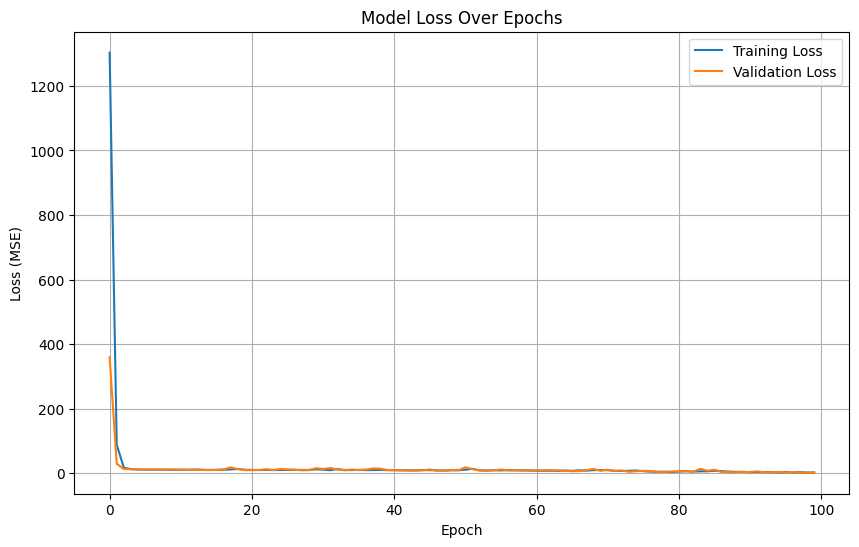

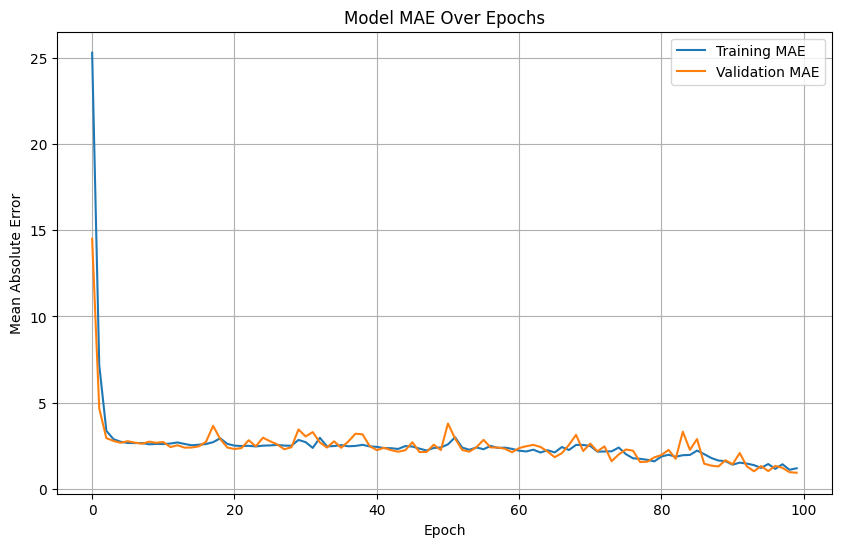

Final Validation Loss (MSE): 1.3234
Final Validation MAE: 0.9417


In [50]:
history = simple_train_model(epochs=100, batch_size=32)

running the optimal value search:

In [52]:
optimal_dmc, optimal_reward = find_optimal_dmc(DMCarr, bounds)
print("Optimal DMC values:", optimal_dmc)
print("Predicted optimal reward:", optimal_reward)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

## Discussion

The program predicted that the optimal DMC set temperatures should be 518 degrees and 998 degrees. Given that our bounds are (250, 500) and (400, 600), the reward function needs more tuning in order to stay within the bounds of our system. We tried different combinations of functions, and did not get a satisfactory result - we may write a continous rather than a linear reward function to address this.

In regards to the training, the final MSE and MAE values are relatively low and stable, indicating that the model has learned a reasonable mapping from goals (inputs) to rewards (outputs).
The small gap between training and validation suggests that the model is generalizing well rather than just memorizing the training data. Monitoring both MSE and MAE provides a more complete picture of performance: MSE helps drive the training optimization, and MAE offers a straightforward “average error” interpretation.

## Summary:

1. The goal is to have an agent control multiple DMC's within a complex process to maximize some value through reinforcement learning
2. Each DMC takes in some start conditions and attempts to optimize them within their own controls, like a PID controller for temperature. The agent only changes the goal, not the behavior itself.
3. The agent wants to maximize a reward, which is a balance between increasing $K_{eq}$ as much as possible, and staying within constraints.

For the baseline model:
1. The process is two DMC's in series.
2. The reward is based on a linear positive reward for $K_{eq}$ and a fixed negative reward for each violation of bounds
3. The exploration is a naive approach of generating data at random points, from fixed start conditions.
4. Due to the naive approach, the training basically becomes supervised learning of finding rewards given our exploration batch.
5. Due to the naive approach, finding the optimal value becomes a search through the supervised model.

We found:
1. The model trained and generalized well
2. We need to adjust our reward function

In the future we hope to:
1. Optimize a far more complex process, with many more DMC's in parallel and in series, with more random fluctuations.
2. Have a more sophisiticated and balanced reward function.
3. Do an exploration based on seeking a better reward rather than the naive approach.
4. Transition from Naive learning to Q-learning, then to more advanced RL algorithms.
